In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from scipy import stats
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Given this dataset of customer information (like name, gender, age, and estimated salary), create a predictive model that's able to determine with a high rate of accuracy whether or not a customer will make a purchase (or even whether or not they will return the product(s)). Identify subtle yet effective patterns that allow for demarcating the target market. 

# FIX THIS LATER

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [14]:
OG_DF = pd.read_csv('Project_3.csv')
OG_DF.head()

,User ID,name,Gender,Age,EstimatedSalary,Purchased
0,10000,Shelby Gregory,Female,47,27752,0
1,10001,Sarah Gutierrez,Female,22,26040,0
2,10002,Daisy Smith,Female,23,91550,0
3,10003,Christopher Anthony,Male,53,94194,0
4,10004,Steven Hood,Male,38,143100,0


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [15]:
modded_df = OG_DF.copy()

modded_df['Is_Purchased'] = 0 
modded_df['Not_Purchased'] = 0
modded_df['Is_Returned'] = 0

modded_df.loc[modded_df['Purchased'] == 0, 'Not_Purchased'] = 1
modded_df.loc[modded_df['Purchased'] == 1, 'Is_Purchased'] = 1 
modded_df.loc[modded_df['Purchased'] == -1, 'Is_Returned'] = 1
modded_df.loc[modded_df['Purchased'] == -1, 'Is_Purchased'] = 1 

modded_df.fillna(0) 
modded_df.drop(columns=['Purchased'], inplace=True)

modded_df.to_csv('092625-0810.csv', index=False)

Text(0, 0.5, 'number of people')

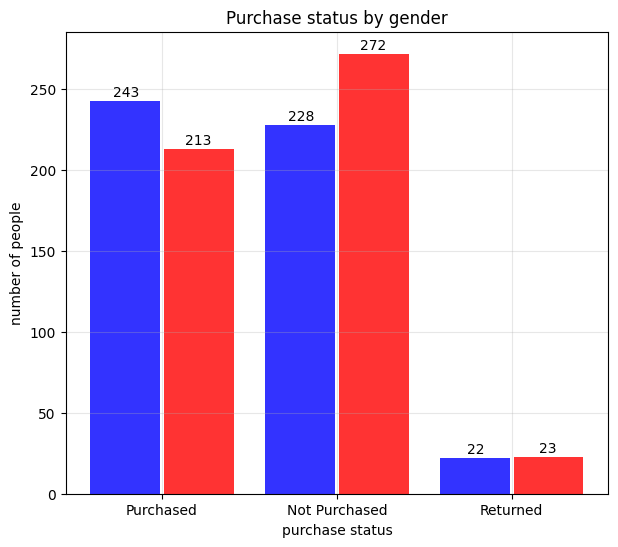

In [28]:
# gender categories
females = OG_DF['Gender'] == 'Female'
males = OG_DF['Gender'] == 'Male'

# purchase status
p1 = OG_DF['Purchased'] == 1
p0 = OG_DF['Purchased'] == 0
p_1 = OG_DF['Purchased'] == -1

# separate males & females for each purchase status
f_p1 = len(OG_DF[(females) & (p1)])
f_p0 = len(OG_DF[(females) & (p0)])
f_p_1 = len(OG_DF[(females) & (p_1)]) 

m_p1 = len(OG_DF[(males) & (p1)]) 
m_p0 = len(OG_DF[(males) & (p0)])
m_p_1 = len(OG_DF[(males) & (p_1)]) 

# put them into lists
p_statuses = ['Purchased', 'Not Purchased', 'Returned']
m_counts = [m_p1, m_p0, m_p_1] 
f_counts = [f_p1, f_p0, f_p_1] 

width = 4
spacing = 0.1
x_pos = [0, 10, 20] 

plt.figure(figsize=(7, 6))

plt.bar([i - width/2 - spacing for i in x_pos], m_counts,
        width=width, alpha=0.8, color='blue', label='male')
plt.bar([i + width/2 + spacing for i in x_pos], f_counts,
        width=width, alpha=0.8, color='red', label='female')

for i, status in enumerate(p_statuses):
    m_count = m_counts[i]
    f_count = f_counts[i]

    plt.text(x_pos[i] - width/2 - spacing/2, 
             m_count+1, str(m_count),
             ha='center', 
             va='bottom', 
             color='black')

    plt.text(x_pos[i] + width/2 + spacing/2, 
             f_count+1, str(f_count),
             ha='center', 
             va='bottom', 
             color='black')

plt.grid(True, alpha=0.3)
plt.title('Purchase status by gender')
plt.xlabel('purchase status')
plt.xticks(x_pos, p_statuses)
plt.ylabel('number of people')

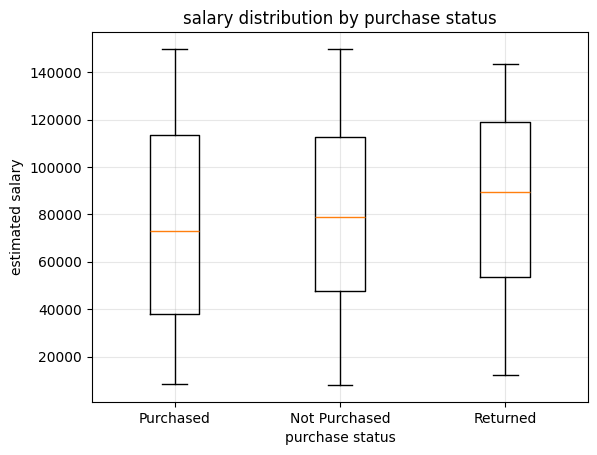

In [37]:
# box plots to visualize correlations btwn salary n purchase status

p1_salaries = OG_DF[p1]['EstimatedSalary']
p0_salaries = OG_DF[p0]['EstimatedSalary'] 
p_1_salaries = OG_DF[p_1]['EstimatedSalary']

salaries = [p1_salaries, p0_salaries, p_1_salaries] 
# p_statuses defined in the kernel above

boxplot = plt.boxplot(salaries, tick_labels=p_statuses,)

plt.xlabel('purchase status')
plt.ylabel('estimated salary')
plt.title('salary distribution by purchase status')
plt.grid(True, alpha=0.3)

plt.show()

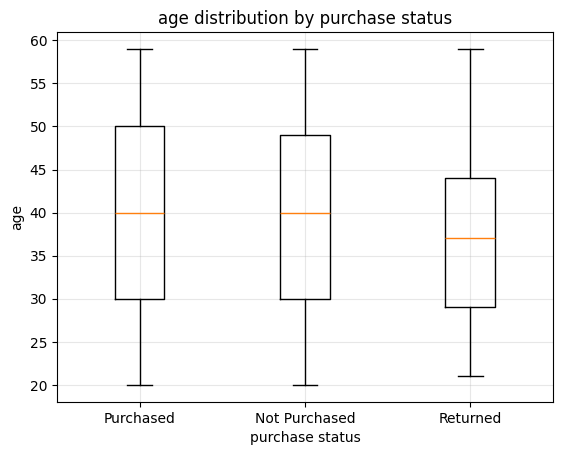

In [38]:
# box plots to visualize correlations btwn age n purchase status

p1_ages = OG_DF[p1]['Age']
p0_ages = OG_DF[p0]['Age'] 
p_1_ages = OG_DF[p_1]['Age']

ages = [p1_ages, p0_ages, p_1_ages] 
# p_statuses defined 2 kernels above

boxplot = plt.boxplot(ages, tick_labels=p_statuses,)

plt.xlabel('purchase status')
plt.ylabel('age')
plt.title('age distribution by purchase status')
plt.grid(True, alpha=0.3)

plt.show()

In [59]:
# analyze the "clumps" of genders 

runs = []
run_len = 1
start_index = 0
gender = OG_DF.iloc[0]['Gender'] 

for i in range(1, len(OG_DF)):
    if OG_DF.iloc[i]['Gender'] == gender:
        run_len += 1
    else:
        runs.append({
            'gender': gender,
            'length': run_len,
            'start_id': OG_DF.iloc[start_index]['User ID'],
            'end_id': OG_DF.iloc[i-1]['User ID'],
            'start_index': start_index,
            'end_index': i-1,
        })
        gender = OG_DF.iloc[i]['Gender']
        run_len = 1
        start_index = i

# add the last run manually
runs.append({
    'gender': gender,
    'length': run_len,
    'start_id': OG_DF.iloc[start_index]['User ID'],
    'end_id': OG_DF.iloc[-1]['User ID'],
    'start_index': start_index,
    'end_index': len(OG_DF) - 1
})

runs_df = pd.DataFrame(runs)
runs_df.head(10)

,gender,length,start_id,end_id,start_index,end_index
0,Female,3,10000,10002,0,2
1,Male,2,10003,10004,3,4
2,Female,1,10005,10005,5,5
3,Male,3,10006,10008,6,8
4,Female,1,10009,10009,9,9
5,Male,2,10010,10011,10,11
6,Female,2,10012,10013,12,13
7,Male,2,10014,10015,14,15
8,Female,1,10016,10016,16,16
9,Male,7,10017,10023,17,23


In [76]:
print(f'median run length: {runs_df["length"].median():.2f}')
print(f'mean run length: {runs_df["length"].mean():.2f}')
print(f'q1: {runs_df["length"].quantile(0.25)}      q3: {runs_df["length"].quantile(0.75)}')

# 5 consecutive genders is a 3.125% chance which is the standard 
# percentage to use when determining whether or not smth is 
# statistically significant 
clumps = runs_df[runs_df['length'] >= 5] 

print('----------clumps----------')
print(f'median clump length: {clumps["length"].median():.2f}')
print(f'mean clump length: {clumps["length"].mean():.2f}')
print(f'q1: {clumps["length"].quantile(0.25)}      q3: {clumps["length"].quantile(0.75)}')
print(f'\n {clumps["length"].value_counts()}\n')
clumps.head(15)

median run length: 2.00
mean run length: 2.05
q1: 1.0      q3: 3.0
----------clumps----------
median clump length: 6.00
mean clump length: 6.13
q1: 5.0      q3: 7.0

 length
5     15
6      7
7      3
8      3
9      2
10     1
Name: count, dtype: int64



,gender,length,start_id,end_id,start_index,end_index
9,Male,7,10017,10023,17,23
10,Female,6,10024,10029,24,29
34,Female,5,10072,10076,72,76
54,Female,8,10109,10116,109,116
55,Male,10,10117,10126,117,126
68,Female,9,10145,10153,145,153
71,Male,8,10157,10164,157,164
83,Male,5,10178,10182,178,182
96,Female,5,10205,10209,205,209
98,Female,6,10211,10216,211,216


In [103]:
# check for statistical significance

# probabilities 
p_male = (OG_DF['Gender'] == 'Male').mean()
p_female = 1 - p_male
print(f'male prob: {p_male*100:.3f}%, female prob: {p_female*100:.3f}%\n')
# basically 50% for each 

expected_max_run = np.log(0.05) / np.log(0.5)
print(f'expected max run length (95% threshold): {expected_max_run:.2f}') # p much same as predicted with the 1/(2^x) < 0.05 rule 
print(f'actual max run length: {runs_df["length"].max()}')

# expected number of runs of length = k:
# E = (n-k+1)*p^k*(1-p)^2 + 2*(p^k)*(1-p)
# do this for each of the lengths in clumps df

counts = clumps['length'].value_counts().to_dict()
n = len(OG_DF)
p = 0.5
for k in counts:
    E = (n-k+1)*(p**k)*(1-p)**2 + 2*(p**k)*(1-p)
    print(f'\nexpected number of runs of length {k}: {E:.5f}')
    print(f'actual number of runs of length {k}: {counts[k]}')

male prob: 49.251%, female prob: 50.749%

expected max run length (95% threshold): 4.32
actual max run length: 10

expected number of runs of length 5: 7.82031
actual number of runs of length 5: 15

expected number of runs of length 6: 3.90625
actual number of runs of length 6: 7

expected number of runs of length 7: 1.95117
actual number of runs of length 7: 3

expected number of runs of length 8: 0.97461
actual number of runs of length 8: 3

expected number of runs of length 9: 0.48682
actual number of runs of length 9: 2

expected number of runs of length 10: 0.24316
actual number of runs of length 10: 1


# 4.Prepare the Data


Apply any data transformations and explain what and why


In [122]:
modded_df.head()
train_df = modded_df.copy()
train_df = pd.get_dummies(train_df, columns=['Gender'], drop_first=False)

X = train_df.drop(columns=['Is_Purchased', 'Not_Purchased', 'Is_Returned'])
y = train_df['Is_Purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

print(f'x train: \n{X_train.head()}')
print(f'x test: \n{X_test.head()}')
print(f'y train: \n{y_train.head()}')
print(f'y test: \n{y_test.head()}')

x train: 
     User ID            name  Age  EstimatedSalary  Gender_Female  Gender_Male
535    10535   Jesse Gardner   20           124035           True        False
696    10696   Ronald Moreno   36            71192          False         True
557    10557     Bianca Roth   50            54517          False         True
643    10643  Thomas Skinner   43           139741           True        False
597    10597      Jacob Wood   33            38700           True        False
x test: 
     User ID             name  Age  EstimatedSalary  Gender_Female  \
521    10521      Doris Bryan   54            65650           True   
941    10941     Laurie Smith   34           118354          False   
741    10741      Angela Cook   36            86381           True   
980    10980    Caitlin Walsh   36            91660           True   
411    10411  William Freeman   56            44652           True   

     Gender_Male  
521        False  
941         True  
741        False  
980       

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [129]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [130]:
input_size = 5 
hidden_size = 50 # can be anywhere from 32-128 
output_size = 1 
num_layers = 2 # can be anywhere from 1-3 

model = LSTMModel(input_size, 
                  hidden_size, 
                  num_layers,
                  output_size)

criterion = nn.BCEWithLogitsLoss() # recommended for binary outputs 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [131]:
num_epochs = 10
for epoch in range(num_epochs):
    # for i, (inputs, labels) in enumerate( 

# FIX LATER : MAKE DATALOADER 

SyntaxError: incomplete input (1667379759.py, line 5)

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
def infrence(prams):
    results = m.run(prams)
    return results 